In [1]:
from mlwpy import *
from helpers import *

# Sample Problems

##### A Toy Problem

<AxesSubplot:xlabel='x1', ylabel='x2'>

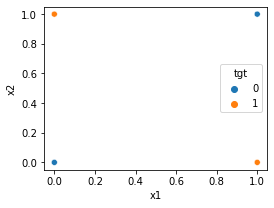

In [2]:
xor_df = make_xor()
sns.scatterplot(data=xor_df, x='x1', y='x2', hue='tgt')

### A Synthetic Dataset

In [3]:
cd_df = make_cats_and_dogs(*cat_dog_nice_sep())

<AxesSubplot:xlabel='height', ylabel='weight'>

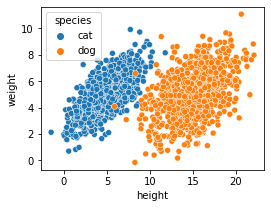

In [4]:
sns.scatterplot(data=cd_df, x='height', y='weight', hue='species')

<AxesSubplot:xlabel='height', ylabel='weight'>

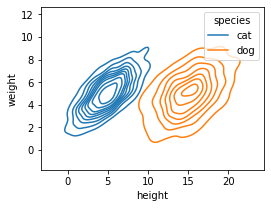

In [5]:
sns.kdeplot(data=cd_df, x='height', y='weight', hue='species')

##### Iris, Again

In [6]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data,
                      columns=iris.feature_names)
iris_ftrs = iris.feature_names
iris_df['tgt'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),tgt
0,5.1000,3.5000,1.4000,0.2000,0
1,4.9000,3.0000,1.4000,0.2000,0
2,4.7000,3.2000,1.3000,0.2000,0
3,4.6000,3.1000,1.5000,0.2000,0
4,5.0000,3.6000,1.4000,0.2000,0


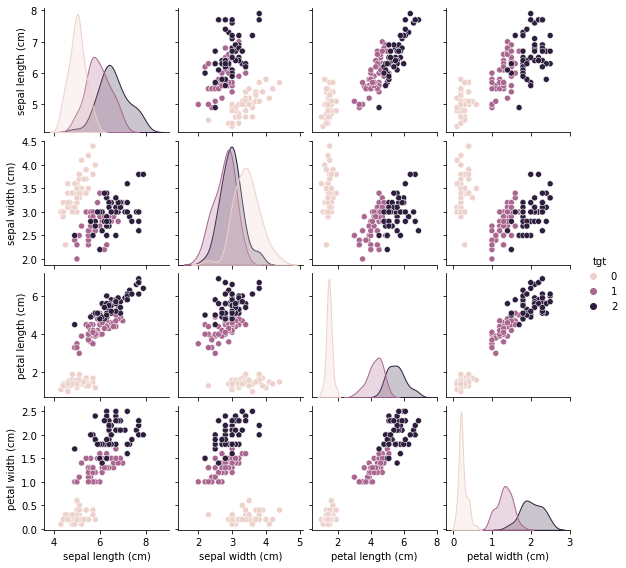

In [7]:
sns.pairplot(iris_df, hue='tgt', height=2);

In [8]:
iris_oneclass_df = iris_df.copy()
iris_oneclass_df['tgt'] = iris.target == 1

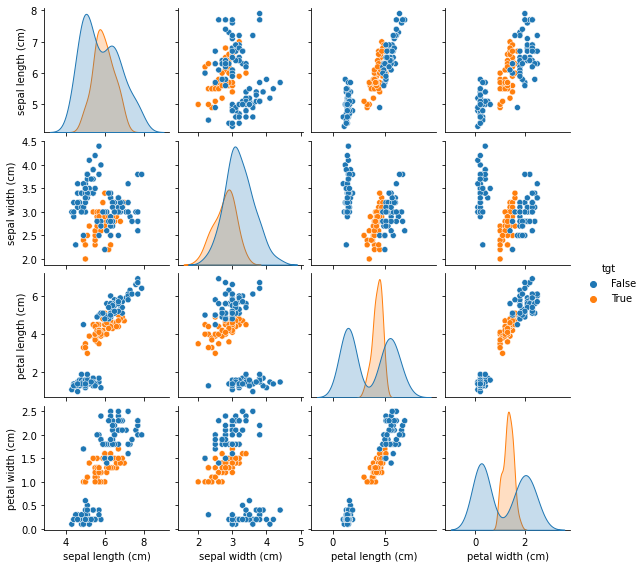

In [9]:
sns.pairplot(iris_oneclass_df, hue='tgt', height=2);

# Decision Tree

##### Decision Tree Form

In [10]:
dtc_xor = (tree.DecisionTreeClassifier(max_depth=2)
               .fit(xor_df[['x1', 'x2']],
                   xor_df['tgt']))

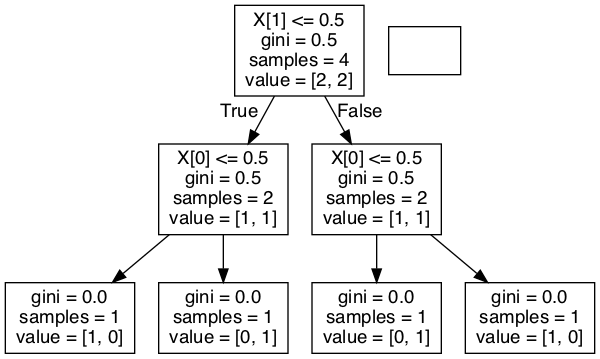

In [11]:
import pydotplus # pip install pydotplus

dot_data = tree.export_graphviz(dtc_xor, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("outputs/xor_tree.png")  # create a file on disk

Image("outputs/xor_tree.png", width=400, height=400)

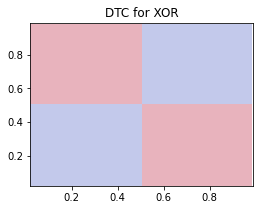

In [12]:
dtc = tree.DecisionTreeClassifier(max_depth=2)
plot_boundary(xor_df[['x1', 'x2']], xor_df['tgt'], [0,1], dtc)
plt.title('DTC for XOR');

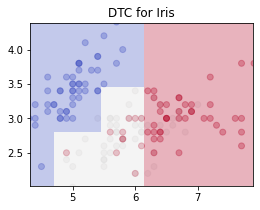

In [13]:
dtc = tree.DecisionTreeClassifier(max_depth=3)
plot_boundary(iris.data, iris.target, [0,1], dtc, 
              show_data=True)
plt.title('DTC for Iris');

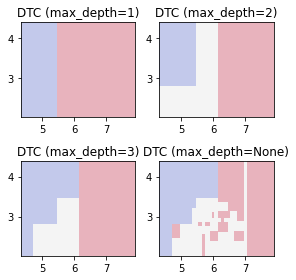

In [14]:
fig, axes = plt.subplots(2,2,figsize=(4,4))

depths = [1, 2, 3, None]
for depth, ax in zip(depths, axes.flat):
    dtc_model = tree.DecisionTreeClassifier(max_depth=depth)
    # so we are only predicting with sepal length and width
    plot_boundary(iris.data, iris.target, [0,1], dtc_model, ax=ax)
    ax.set_title("DTC (max_depth={})".format(dtc_model.max_depth))

plt.tight_layout()

### Decision Trees:  Train-Test and Building

In [15]:
tts_1c = skms.train_test_split(iris.data, iris.target==1, 
                               test_size=.33, random_state = 21)
(iris_1c_train_ftrs, iris_1c_test_ftrs, 
 iris_1c_train_tgt,  iris_1c_test_tgt) = tts_1c

In [16]:
iris_1c_tree = (tree.DecisionTreeClassifier()
                    .fit(iris_1c_train_ftrs, 
                         iris_1c_train_tgt))

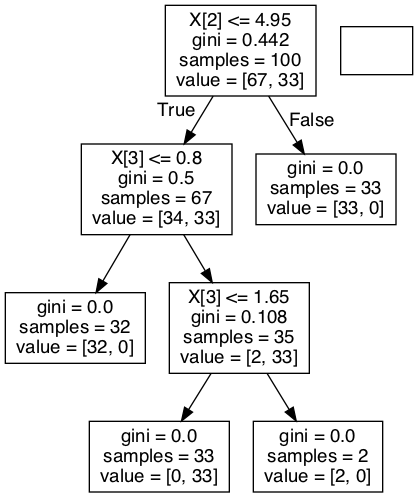

In [17]:
dot_data = tree.export_graphviz(iris_1c_tree, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("outputs/iris_1c.png")
Image("outputs/iris_1c.png", width=275, height=275)

In [18]:
metrics.accuracy_score(iris_1c_tree.predict(iris_1c_test_ftrs),
                       iris_1c_test_tgt)

0.94

In [19]:
dtc = tree.DecisionTreeClassifier()
skms.cross_val_score(dtc, iris.data, iris.target, 
                     cv=3, 
                     scoring='accuracy')

array([0.98, 0.92, 1.  ])

# Overfitting

In [20]:
depths = [1, 2, 3, 4, None]
results=[]

for max_depth in depths:
    dtc = tree.DecisionTreeClassifier(max_depth=max_depth)
    scores = skms.cross_val_score(dtc, iris.data, iris.target, 
                                  cv=5, 
                                  scoring='accuracy')
    results.append((max_depth, np.mean(scores)))
pd.DataFrame.from_records(results)

,0,1
0,1.0000,0.6667
1,2.0000,0.9333
2,3.0000,0.9600
3,4.0000,0.9667
4,NaN,0.9667


In [21]:
faux_train_ftr = np.random.random(size=(len(iris_1c_train_ftrs),1))
faux_test_ftr  = np.random.random(size=(len(iris_1c_test_ftrs), 1))

iris_1c_tree = (tree.DecisionTreeClassifier()
                    .fit(faux_train_ftr, iris_1c_train_tgt))

In [22]:
print(iris_1c_tree.tree_.node_count)

95


In [23]:
print(iris_1c_tree.tree_.max_depth)

18


In [24]:
acc = metrics.accuracy_score
on_train = acc(iris_1c_tree.predict(faux_train_ftr),
               iris_1c_train_tgt)
on_test = acc(iris_1c_tree.predict(faux_test_ftr),
              iris_1c_test_tgt)

In [25]:
print("on training:", on_train)
print("on testing:", on_test)

on training: 1.0
on testing: 0.58


# Support Vector Classifiers

##### Margins and Support Vectors

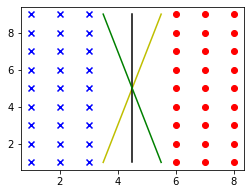

In [26]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

# fancy way to get cross-product of points
left  = np.mgrid[1:4.0, 1:10].reshape(2, -1).T
right = np.mgrid[6:9.0, 1:10].reshape(2, -1).T

# data points
ax.scatter(left[:,0] , left[:,1] , c='b', marker='x')
ax.scatter(right[:,0], right[:,1], c='r', marker='o')

# separating lines
ax.plot([3.5, 5.5], [1,9], 'y')
ax.plot([4.5, 4.5], [1,9], 'k')
ax.plot([3.5, 5.5], [9,1], 'g');

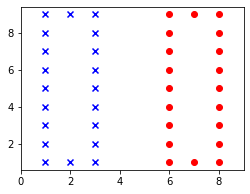

In [27]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

# fancy way to get cross-product of points
left  = np.mgrid[1:4:2, 1:10].reshape(2, -1).T
right = np.mgrid[6:9:2, 1:10].reshape(2, -1).T

ax.scatter(left[:,0] , left[:,1] , c='b', marker='x')
ax.scatter([2,2], [1,9], c='b', marker='x')
ax.scatter(right[:,0], right[:,1], c='r', marker='o')
ax.scatter([7,7], [1,9], c='r', marker='o')
ax.set_xlim(0,9);

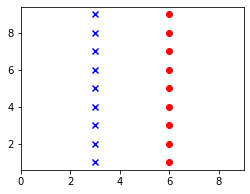

In [28]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

left  = np.mgrid[3:4, 1:10].reshape(2, -1).T
right = np.mgrid[6:7, 1:10].reshape(2, -1).T

ax.scatter(left[:,0] , left[:,1] , c='b', marker='x')
ax.scatter(right[:,0], right[:,1], c='r', marker='o')
ax.set_xlim(0,9);

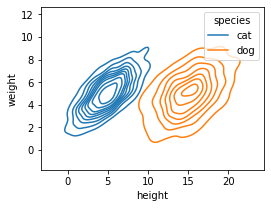

In [29]:
sns.kdeplot(data=cd_df, x='height', y='weight', hue='species');

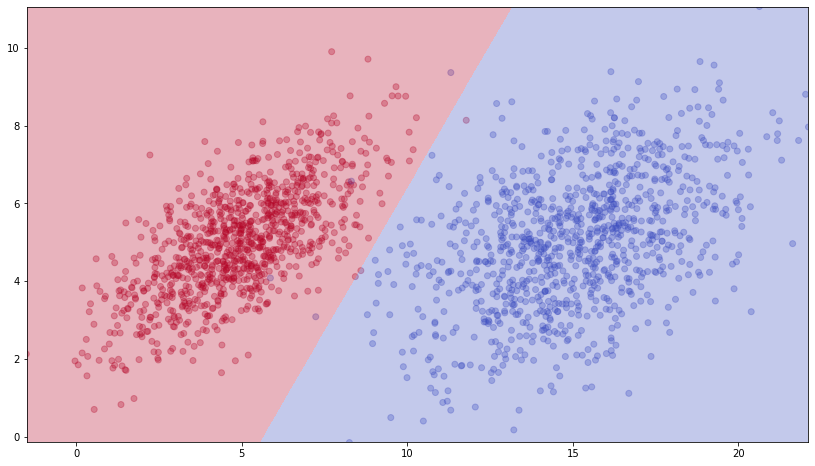

In [30]:
fig, axes = plt.subplots(1,1,figsize=(14,8))
tgt = cd_df['species']=='cat'
svm_mod = plot_boundary(cd_df.values, tgt, [0,1],
                        svm.SVC(kernel='linear'),
                        show_data=True)

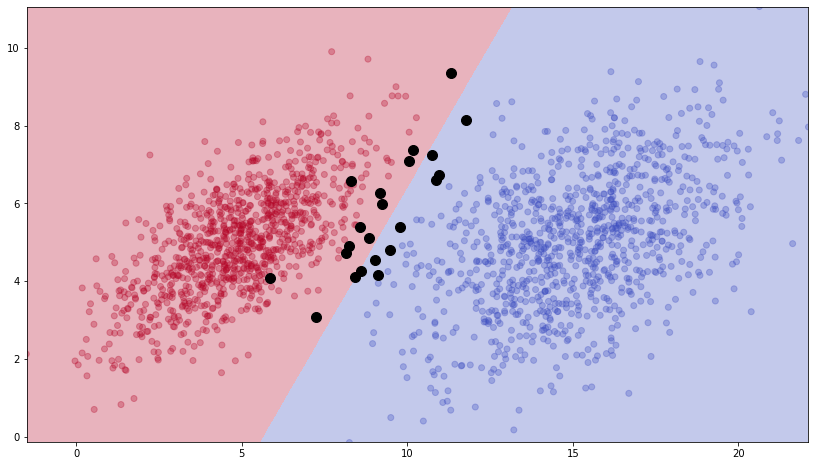

In [31]:
fig, axes = plt.subplots(1,1,figsize=(14,8))
tgt = cd_df['species']=='cat'
svm_mod = plot_boundary(cd_df.values, tgt, [0,1],
                        svm.SVC(kernel='linear'),
                        show_data=True)

sv_dex = np.zeros_like(tgt, dtype=bool)
sv_dex[svm_mod.support_] = True
plt.scatter(cd_df.iloc[sv_dex, 0], 
            cd_df.iloc[sv_dex, 1], 
            marker='o', s=100, c='k');

##### Penalty Parameters for SVC

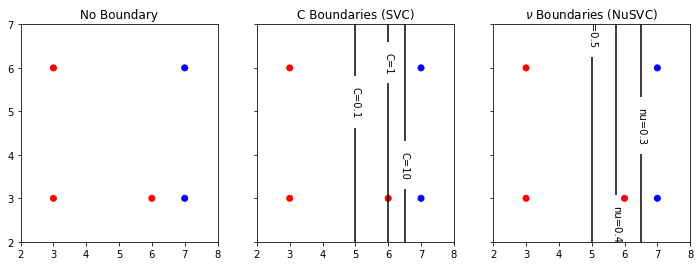

In [32]:
ftrs = np.array([[3,3],
                 [3,6],
                 [7,3],
                 [7,6],
                 [6,3]])
tgt  = np.array([0,0,1,1,0])
colors = np.array(['r', 'b'])

Cs = [.1, 1.0, 10]
nus = [.3, .4, .5]

fig, axes = plt.subplots(1,3,figsize=(12,4),
                         sharex=True, sharey=True)
for ax in axes:
    ax.scatter(ftrs[:,0], ftrs[:,1], c=colors[tgt])
ax.set_xlim(2,8); ax.set_ylim(2,7)

do_linear_svc_separators(svm.SVC, ftrs, tgt,
                         "C", Cs, axes[1])
do_linear_svc_separators(svm.NuSVC, ftrs, tgt,
                         "nu", nus, axes[2])

axes[0].set_title("No Boundary")
axes[1].set_title("C Boundaries (SVC)")
axes[2].set_title(r"$\nu$ Boundaries (NuSVC)");

In [ ]:
# SVC Cost = SVC Errors + SVC Complexity

##### Picking a Good Penalty

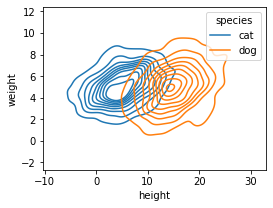

In [33]:
cd_df = make_cats_and_dogs(*cat_dog_overlap())
sns.kdeplot(data=cd_df, x='height', y='weight', hue='species');

In [34]:
ftrs = cd_df[['height', 'weight']]
tgt = cd_df['species']=='cat'

In [35]:
nus = np.linspace(0.05, .999, 9)
vc = skms.validation_curve(svm.NuSVC(kernel='linear'), 
                           ftrs, tgt, 
                           param_name='nu',
                           param_range=nus,
                           cv=5)

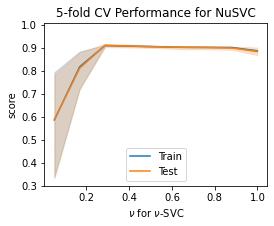

In [36]:
fig,ax = plt.subplots(1,1,figsize=(4,3))

tidy_df = sk_graph_to_tidy(vc, nus, 'nu', 5)
ax = sns.lineplot(x='nu', y='score', hue='set', data=tidy_df)

ax.set_title('5-fold CV Performance for NuSVC')
ax.set_xlabel("\n".join([r'$\nu$ for $\nu$-SVC']))
ax.set_ylim(.3, 1.01)
ax.legend(loc='lower center');

In [37]:
cs = [0.0001, 0.001, 0.01, .1, 1.0, 10, 100, 1000]
vc = skms.validation_curve(svm.SVC(kernel='linear'), 
                           ftrs, tgt, 
                           param_name='C',
                           param_range=cs,
                           cv=5)

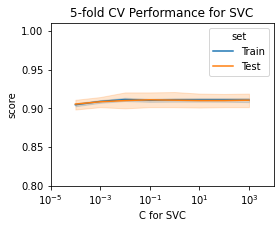

In [38]:
fig,ax = plt.subplots(1,1,figsize=(4,3))

tidy_df = sk_graph_to_tidy(vc, cs, 'c', 5)
ax = sns.lineplot(x='c',y='score',hue='set',data=tidy_df)

ax.set_title('5-fold CV Performance for SVC')
ax.set_xlabel("\n".join([r'C for SVC']))
ax.set_ylim(.8, 1.01)
ax.set_xlim(.00001, 10001)
ax.set_xscale('log')